In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file
from evals import evaluate,evaluate_mae_with_confidence,influence
from evals import euclidean_distance, manhattan_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [4]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [5]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/epoch_500/_fedl_global_500.pth'))

<All keys matched successfully>

In [8]:
modified_model = ShallowNN(features)
modified_model.load_state_dict(torch.load('checkpt/test/epoch_500/20_rounds_25_epochs_per_round/_fedl_global_20_25.pth'))

<All keys matched successfully>

In [9]:
eval_list = []
for client in client_ids:
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/epoch_500/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    isolated_mae,(iso_lower_band, iso_upper_band), _  = evaluate_mae_with_confidence(isolated_model, val_loader)
    federated_mae,(fed_lower_band, fed_upper_band), _ = evaluate_mae_with_confidence(global_model, val_loader)
    modified_mae,(mod_lower_band, mod_upper_band), _ = evaluate_mae_with_confidence(modified_model, val_loader)
    
    eval_dict = {"client_id":client, "Isolated Average MAE": round(isolated_mae, 4),
                 "Isolated MAE lower band":round(iso_lower_band,4),
                 "Isolated MAE upper band":round(iso_upper_band,4),
                 "Federated Average MAE" :round(federated_mae, 4),
                "Federated MAE lower band": round(fed_lower_band, 4),
                "Federated MAE upper band":round(fed_upper_band,4),
                "Modified model Average MAE" :round(modified_mae, 4),
                "Modified model MAE lower band": round(mod_lower_band, 4),
                "Modified model MAE upper band":round(mod_upper_band,4)}
    eval_list.append(eval_dict)
    #print(client,eval_dict)
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

In [10]:
eval_df

,client_id,Isolated Average MAE,Isolated MAE lower band,Isolated MAE upper band,Federated Average MAE,Federated MAE lower band,Federated MAE upper band,Modified model Average MAE,Modified model MAE lower band,Modified model MAE upper band,clients
0,0_0,0.4249,0.4043,0.4451,0.4335,0.4188,0.4467,0.4343,0.4170,0.4536,1
1,0_1,0.4465,0.4304,0.4650,0.4554,0.4388,0.4724,0.4468,0.4320,0.4645,2
2,0_2,0.2876,0.2759,0.3005,0.3274,0.3143,0.3410,0.3167,0.3034,0.3309,3
3,0_3,0.3507,0.3368,0.3655,0.3907,0.3757,0.4054,0.4022,0.3848,0.4182,4
4,0_4,0.2902,0.2780,0.3037,0.3067,0.2937,0.3194,0.3168,0.3022,0.3313,5
5,0_5,0.4101,0.3809,0.4534,0.4423,0.4219,0.4687,0.5495,0.4167,0.8996,6
6,1_0,0.4947,0.4793,0.5112,0.4746,0.4594,0.4879,0.5093,0.4918,0.5262,7
7,1_1,0.4876,0.4699,0.5063,0.4638,0.4493,0.4799,0.5036,0.4862,0.5265,8
8,1_2,0.4299,0.4150,0.4445,0.4050,0.3917,0.4176,0.4287,0.4125,0.4456,9
9,1_3,0.4478,0.4324,0.4639,0.4970,0.4822,0.5138,0.5020,0.4832,0.5168,10


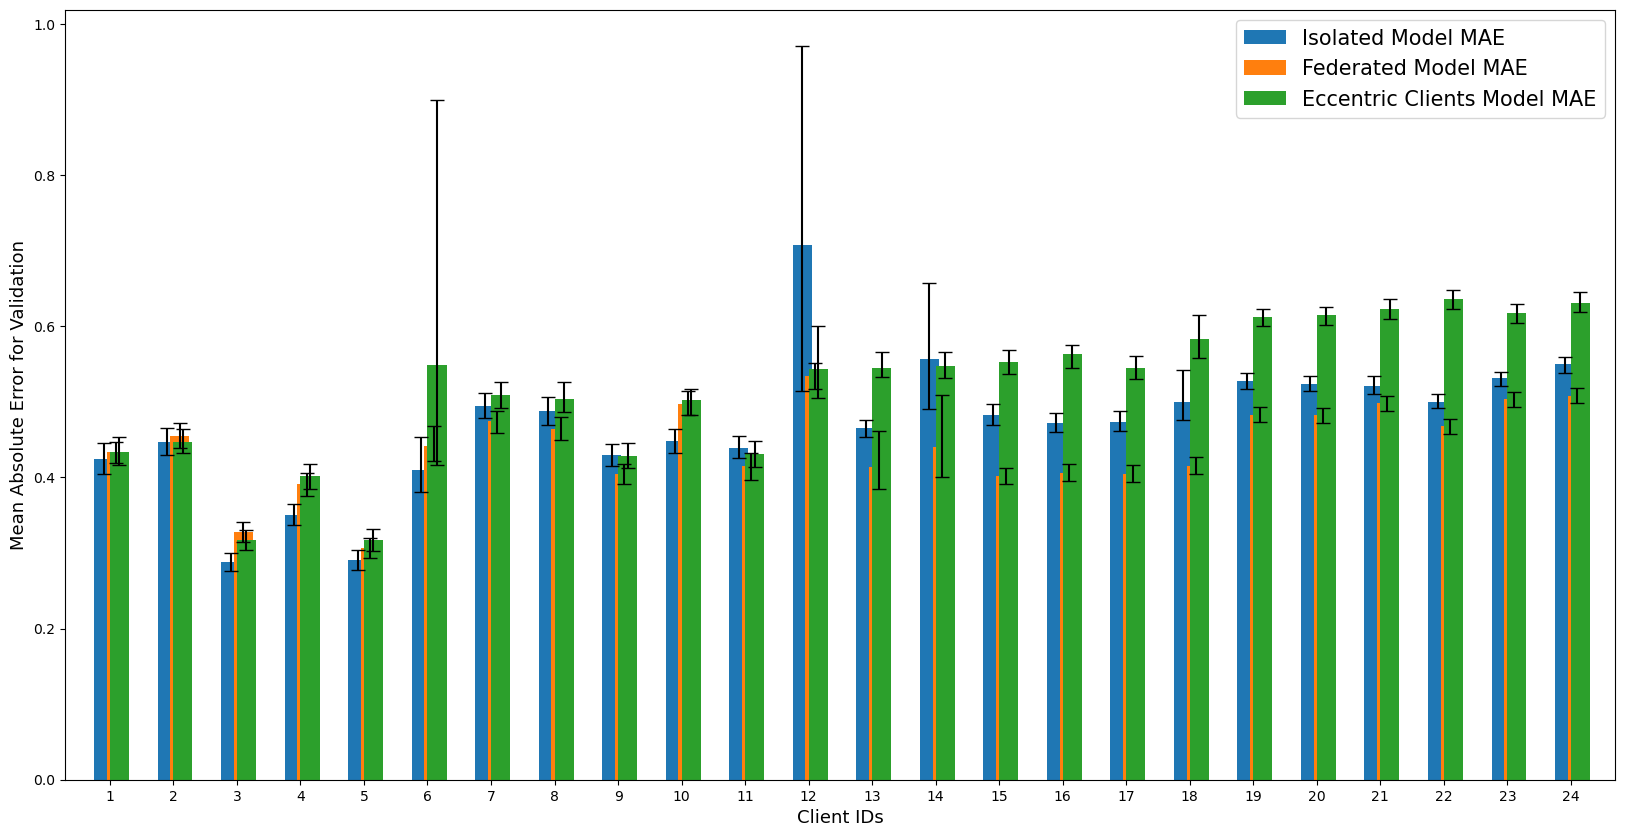

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.3  # Decrease the bar width
index = eval_df.index

bar1 = ax.bar(index - bar_width / 3, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index + bar_width / 3, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

bar3 = ax.bar(index + bar_width / 2, eval_df['Modified model Average MAE'], bar_width, yerr=[
    (eval_df["Modified model Average MAE"] - eval_df["Modified model MAE lower band"]),
    (eval_df['Modified model MAE upper band'] - eval_df["Modified model Average MAE"])
], capsize=5, label='Eccentric Clients Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.7, index[-1] + 0.7)

plt.show()

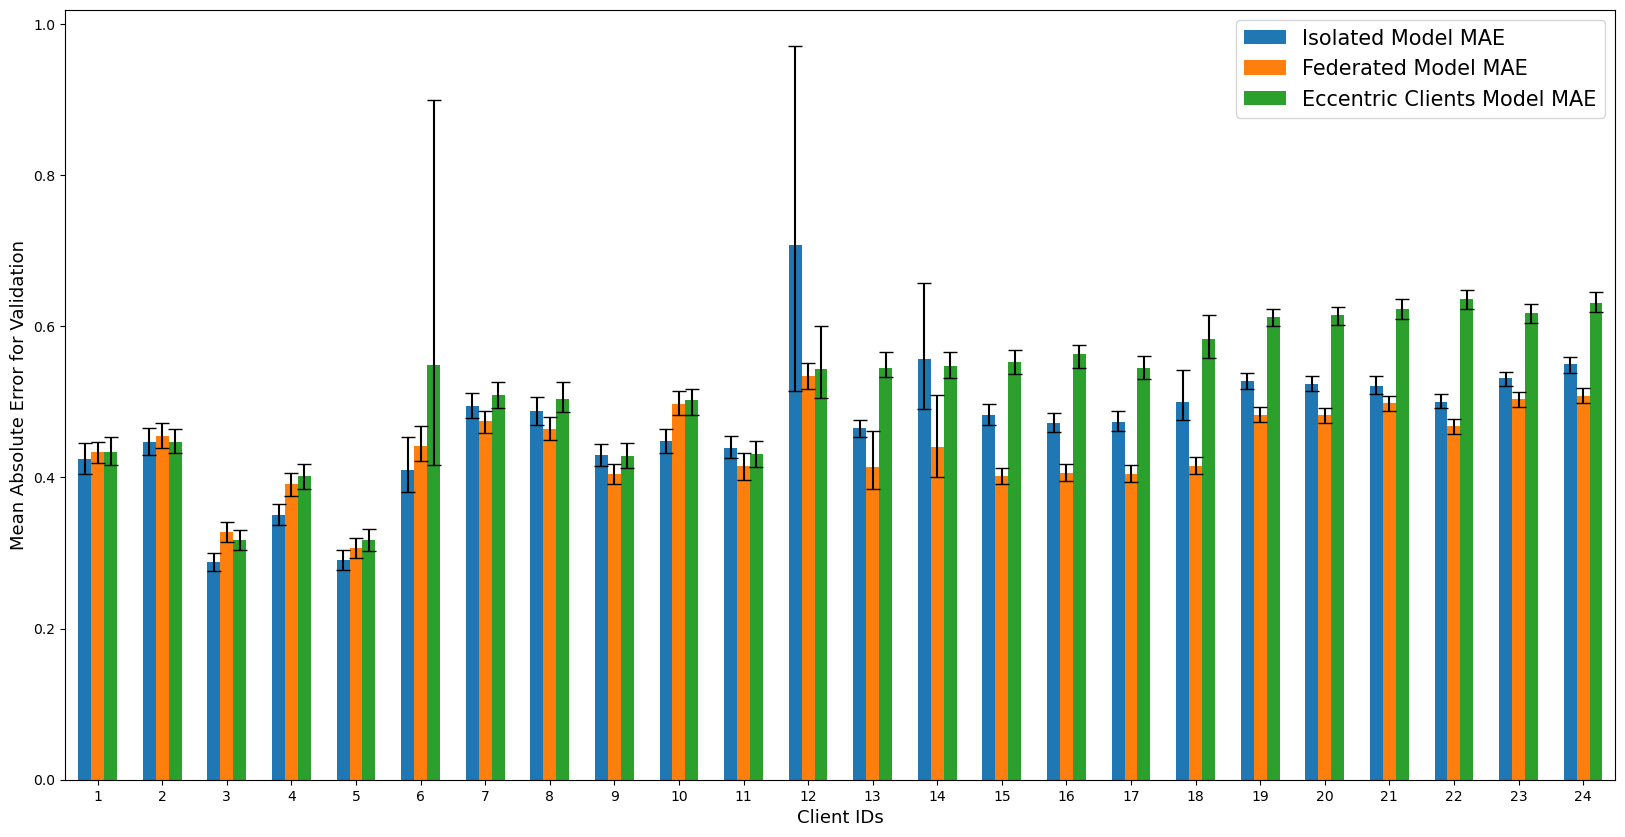

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.2  # Decrease the bar width
index = np.arange(len(eval_df))

bar1 = ax.bar(index - bar_width, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

bar3 = ax.bar(index + bar_width, eval_df['Modified model Average MAE'], bar_width, yerr=[
    (eval_df["Modified model Average MAE"] - eval_df["Modified model MAE lower band"]),
    (eval_df['Modified model MAE upper band'] - eval_df["Modified model Average MAE"])
], capsize=5, label='Eccentric Clients Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.5, index[-1] + 0.5)

plt.show()
